-> Google Stock Price Prediction using Facebook Prophet

Forecasting Google's closing stock price using Meta's Prophet model  
a time series forecasting tool built for business data with seasonal trends.

Dataset: Google (GOOG) historical stock data from Yahoo Finance  
Model: Facebook Prophet with daily seasonality  
Forecast horizon: 365 days ahead

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../dataset/GOOG.csv')
print(df.shape)
print(df.dtypes)
df.head()

(252, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-09,1197.989990,1203.880005,1183.603027,1188.010010,1188.010010,1065700
1,2019-08-12,1179.209961,1184.959961,1167.671997,1174.709961,1174.709961,1003000
2,2019-08-13,1171.459961,1204.780029,1171.459961,1197.270020,1197.270020,1294400
3,2019-08-14,1176.310059,1182.300049,1160.540039,1164.290039,1164.290039,1578700
4,2019-08-15,1163.500000,1175.839966,1162.109985,1167.260010,1167.260010,1218700


-> Exploratory Data Analysis
Plotting the historical closing price to understand the trend before modelling.

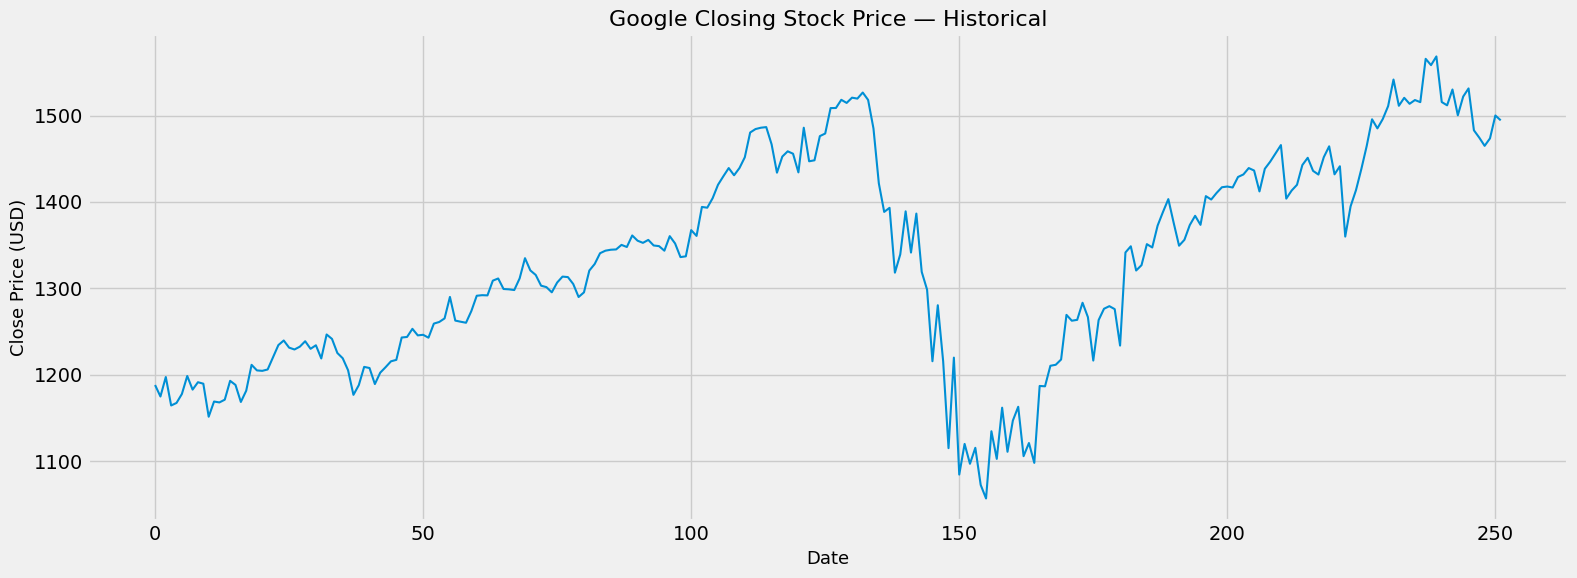

In [3]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 6))
plt.title('Google Closing Stock Price — Historical', fontsize=16)
plt.plot(df['Close'], linewidth=1.5)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Close Price (USD)', fontsize=13)
plt.tight_layout()
plt.savefig('../images/closing_price.png', dpi=150)
plt.show()

-> Data Preparation
Prophet requires exactly two columns: `ds` (datestamp) and `y` (value to forecast).

In [4]:
data = df[['Date', 'Close']].copy()
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})

# Make sure ds is datetime
data['ds'] = pd.to_datetime(data['ds'])

print(data.shape)
data.head()

(252, 2)


,ds,y
0,2019-08-09,1188.010010
1,2019-08-12,1174.709961
2,2019-08-13,1197.270020
3,2019-08-14,1164.290039
4,2019-08-15,1167.260010


-> Model Training
Fitting the Prophet model with daily seasonality enabled.
Prophet automatically handles trend + weekly + yearly seasonality.

In [5]:
m = Prophet(daily_seasonality=True)
m.fit(data)
print("Model trained successfully.")

12:20:30 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully.


-> Forecasting — 365 Days Ahead
`make_future_dataframe` extends the date range by 365 days beyond the last data point.
`yhat` = predicted value, `yhat_lower` and `yhat_upper` = confidence interval.

In [6]:
future = m.make_future_dataframe(periods=365)
predictions = m.predict(future)

# Show key columns
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
607,2021-07-29,2102.531746,-57.281456,4268.250433
608,2021-07-30,2101.688577,-60.212483,4277.687899
609,2021-07-31,2104.805208,-88.200221,4294.355487
610,2021-08-01,2106.412107,-78.749151,4272.280430
611,2021-08-02,2104.935816,-76.015342,4307.964468
612,2021-08-03,2107.608966,-106.740340,4311.216830
613,2021-08-04,2113.645678,-78.477239,4323.045124
614,2021-08-05,2113.780047,-106.877740,4337.241647
615,2021-08-06,2112.936878,-110.066131,4330.600859
616,2021-08-07,2116.053509,-132.630087,4375.105267


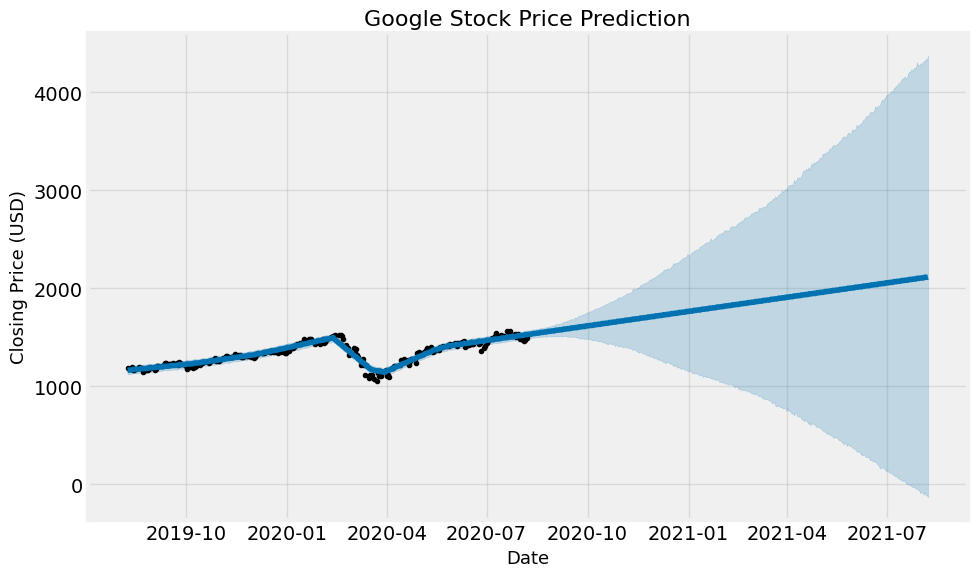

In [7]:
fig = m.plot(predictions)
plt.title('Google Stock Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Closing Price (USD)', fontsize=13)
plt.tight_layout()
plt.savefig('../images/prediction.png', dpi=150)
plt.show()

-> Seasonal Components
Breaking down the forecast into trend, weekly seasonality, and yearly seasonality.
This tells us *why* the model predicts what it predicts.

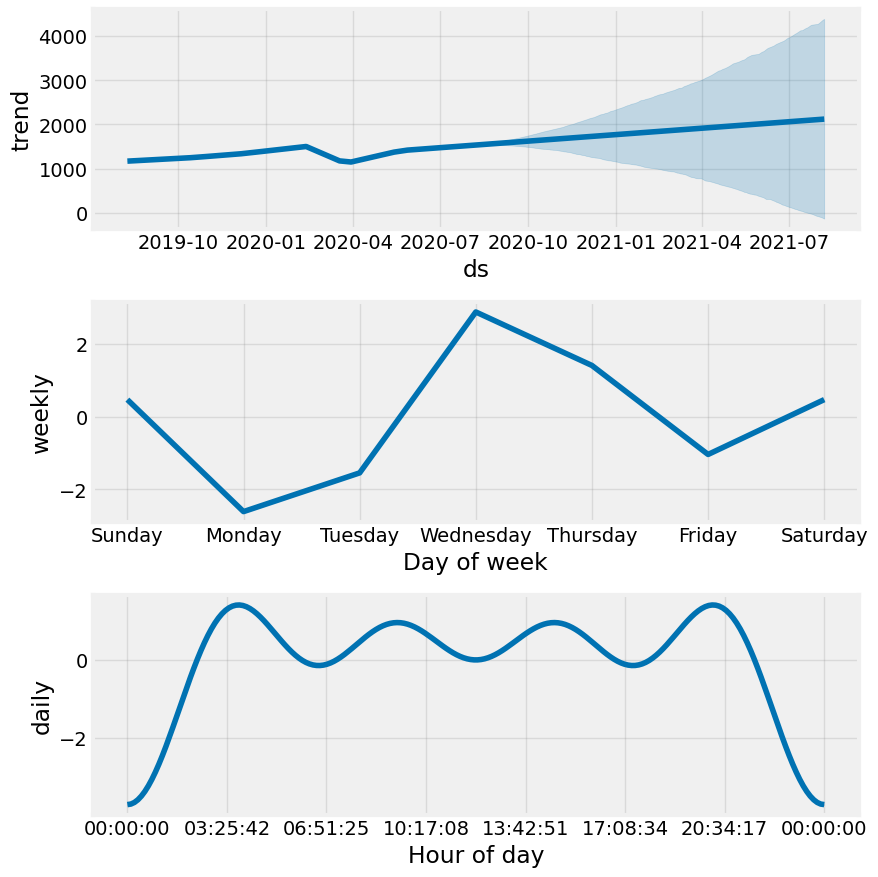

In [8]:
fig2 = m.plot_components(predictions)
plt.tight_layout()
plt.savefig('../images/components.png', dpi=150)
plt.show()

-> Results

| Metric | Value |
|--------|-------|
| Training data | GOOG historical closing prices |
| Forecast horizon | 365 days |
| Model | Facebook Prophet (daily seasonality) |
| Trend | Strong upward long-term trend |
| Weekly pattern | Slight dip on Mondays |
| Yearly pattern | Higher activity mid-year |

Key observation: Prophet decomposes the forecast into trend + seasonality components,  
making it highly interpretable compared to black-box models like LSTM.